In [1]:
from dataset import get_train_loader
from model import MultiViewRNN
from utils import _load_config,load_checkpoint
import torch.optim as optim 
import torch
from metrics import crossview_ap
import torch.nn.functional as F
import os 
from loss import contrastive_loss

In [2]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config_file=_load_config()


In [4]:
#checkpoint_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/checkpoints5/checkpoint_epoch_20.pth.tar'
#step = load_checkpoint(torch.load(checkpoint_path), model, optimizer)

In [6]:
csv_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset/sampled_devset(1).csv'
loader=get_train_loader(csv_path,batch_size=config_file['train_batch_size'],loss_fn=config_file['loss_fn'])

In [17]:
path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/checkpoints5'
checkpoints=os.listdir(path)
len(checkpoints)

20

In [4]:
total_loss=[]


In [18]:
from tqdm import tqdm 
for epoch in range(4,len(checkpoints)):
    
    model=MultiViewRNN(config_file=config_file)
    optimizer = optim.Adam(model.parameters(), lr=config_file["lr"], weight_decay=config_file['weight_decay'])

    root_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/checkpoints5'
    checkpoint_name=f'checkpoint_epoch_{epoch+1}.pth.tar'
    checkpoint_path=os.path.join(root_path,checkpoint_name)
    step = load_checkpoint(torch.load(checkpoint_path), model, optimizer)

    model=model.to(DEVICE)
    average_loss=0

    for idx,batch in tqdm(
            enumerate(loader), total=len(loader), leave=False
        ):
        batch['view1_x1']=batch['view1_x1'].view(-1,batch['view1_x1'].shape[2],batch['view1_x1'].shape[1])
        batch['view1_x2']=batch['view1_x2'].view(-1,batch['view1_x2'].shape[2],batch['view1_x2'].shape[1])
            
        batch['view1_x1']=batch['view1_x1'].to(DEVICE)
        batch['view1_x2']=batch['view1_x2'].to(DEVICE)
        batch['view2_c1']=batch['view2_c1'].to(DEVICE)
        batch['view2_c2']=batch['view2_c2'].to(DEVICE)
        lev_distance=batch['edit_distance']

        output=model(batch)
        x1=output['x1']
        x2=output['x2']
        c1=output['c1']
        c2=output['c2']

        loss=contrastive_loss(obj=config_file["loss_fn"],
                                  margin=config_file["margin"],
                                  x1=x1,
                                  c1=c1,
                                  c2=c2,
                                  x2=x2,
                                  lev_distance=lev_distance,
                                  t_max=config_file['t_max'])
        average_loss+=loss
    
    average_loss=average_loss/len(loader)

    total_loss.append(average_loss.item())

    del model 
    del optimizer
    torch.cuda.empty_cache()



=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


=> loading checkpoint


In [20]:
len(total_loss)

20

In [21]:
torch.cuda.empty_cache()

In [1]:
! nvidia-smi

Thu Jul  4 05:22:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000001:00:00.0 Off |                  Off |
| N/A   43C    P0             26W /   70W |    4373MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Text(0.5, 1.0, 'Dev loss across epochs')

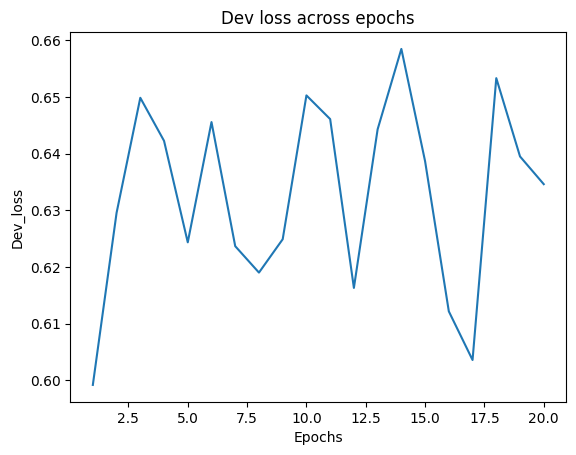

In [22]:
import matplotlib.pyplot as plt 

epochs=[i for i in range(1,len(checkpoints)+1)]
plt.plot(epochs,total_loss)

plt.xlabel("Epochs")
plt.ylabel("Dev_loss")

plt.title("Dev loss across epochs")

In [ ]:
# overfitting due to less data 
# sampling more data ,use lr_scheduler l2 regularization ,normalization